# Building an XGBoost model by creating the underlying logic in python

### Importing required packages

In [118]:
import numpy as np
import pandas as pd
from collections import defaultdict
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split

from sklearn import datasets

### Read in sample dataset

In [119]:
data, _ = datasets.load_wine(as_frame=True, return_X_y=True)

In [120]:
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


We will use the xgboost model to predict the housing value based on some of the features above. For simplicity, I'm dropping coordinate features.

In [121]:
data.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

### Basic data analysis

In [140]:
len(data)

178

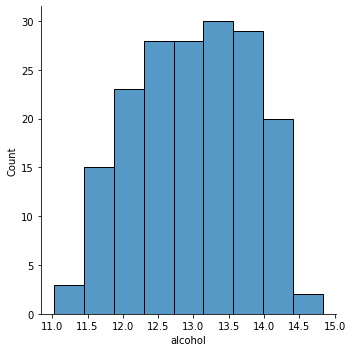

In [122]:
sns.displot(data['alcohol'])

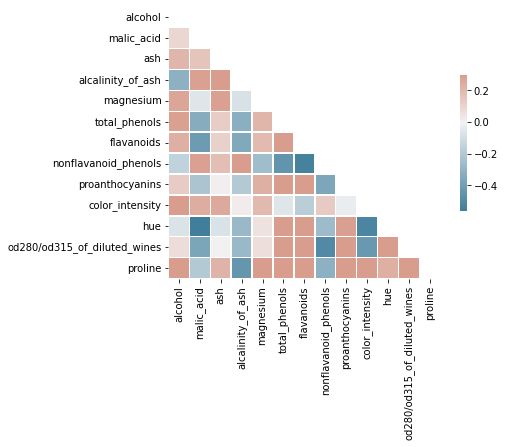

In [123]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

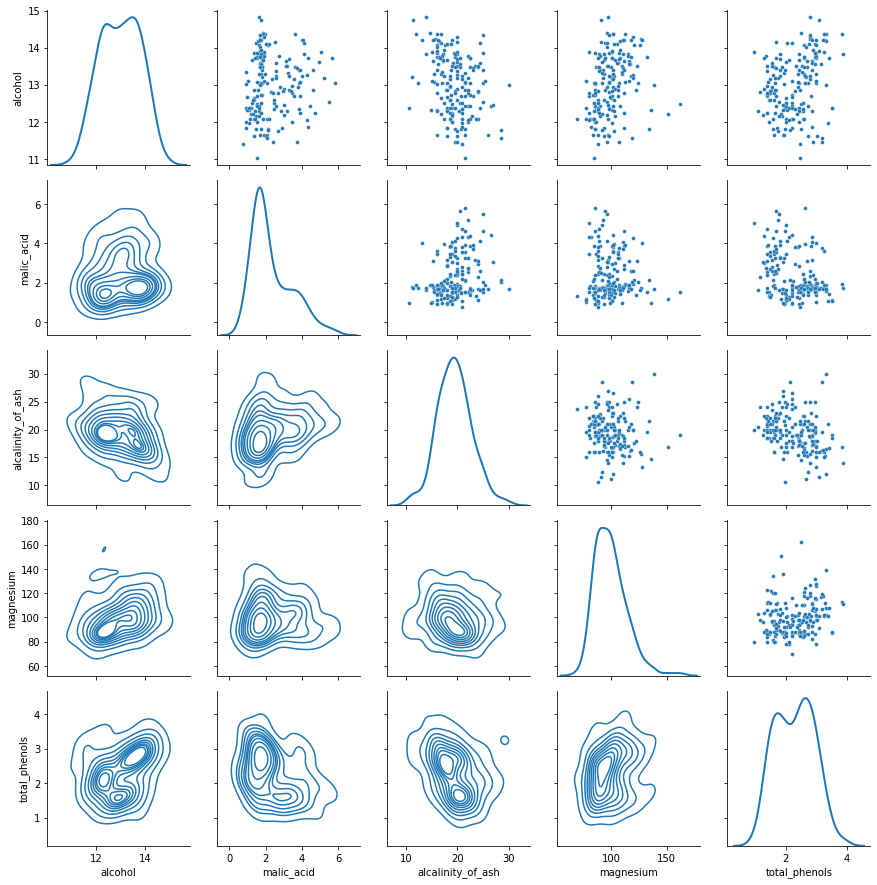

In [124]:
g = sns.PairGrid(data[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'magnesium',
       'total_phenols']], 
       diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

Basic analysis:
1. Low kutosis in data
2. Target is fairly/evenly represented in data
3. No heavily correlated features
4. No major outliers
5. Small dataset with 178 observations, could be prone to over-fitting

### Set up data for training

In [125]:
X = data[['malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline']]

y = data['alcohol']

In [126]:
X.head()

,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [127]:
y

0      14.23
1      13.20
2      13.16
3      14.37
4      13.24
       ...  
173    13.71
174    13.40
175    13.27
176    13.17
177    14.13
Name: alcohol, Length: 178, dtype: float64

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=43)

In [129]:
y_train

97     12.29
53     13.77
20     14.06
30     13.73
160    12.36
       ...  
58     13.72
21     12.93
49     13.94
64     12.17
68     13.34
Name: alcohol, Length: 124, dtype: float64

### Defining the xgboost model

The model has a couple key parameters:
1. learning_rate
Step size taken at each iteration while minimizing a loss function.

2. base_score
For a binary case (not multi-class) the base score is the initial prediction (global bias).

3. max_depth
XGBoost uses max_depth parameter as specified the stopping criteria for the splitting of the branch, and starts pruning trees backward.

4. subsample
Randomly sample a portion of the data to prevent overfitting.

In [130]:
class XGBoostModel():
    '''XGBoost from Scratch
    '''
    
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(lambda: None, params)
        self.subsample = self.params['subsample'] if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)

    def fit(self, X, y, objective, num_boost_round, verbose=False):
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        self.boosters = []
        for i in range(num_boost_round):

            """
            Compute gradients and hessians of target vector with respect
            to current predictions.

            We use this in fitting the tree booster
            """
            gradients = objective.gradient(y, current_predictions)
            hessians = objective.hessian(y, current_predictions)
            sample_idxs = None if self.subsample == 1.0 \
                else self.rng.choice(len(y), 
                                     size=math.floor(self.subsample*len(y)), 
                                     replace=False)
                
            """
            Calling of the tree booster method

            Passing in the gradients and hessians of the target vector
            for use in evaluating splits in the tree
            """
            booster = TreeBooster(X, gradients, hessians, 
                                  self.params, self.max_depth, sample_idxs)
            current_predictions += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            if verbose: 
                print(f'[{i}] train loss = {objective.loss(y, current_predictions)}')
            
    def predict(self, X):
        return (self.base_prediction + self.learning_rate 
                * np.sum([booster.predict(X) for booster in self.boosters], axis=0))

In [131]:
class TreeBooster():
 
  def __init__(self, X, g, h, params, max_depth, idxs=None):
      self.params = params
      self.max_depth = max_depth
      assert self.max_depth >= 0, 'max_depth must be nonnegative'
      self.min_child_weight = params['min_child_weight'] \
          if params['min_child_weight'] else 1.0
      self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0
      self.gamma = params['gamma'] if params['gamma'] else 0.0
      self.colsample_bynode = params['colsample_bynode'] \
          if params['colsample_bynode'] else 1.0
      if isinstance(g, pd.Series): g = g.values
      if isinstance(h, pd.Series): h = h.values
      if idxs is None: idxs = np.arange(len(g))
      self.X, self.g, self.h, self.idxs = X, g, h, idxs
      self.n, self.c = len(idxs), X.shape[1]

      """
      Compute the optimal weight (w*_j) of leaf j
      """
      self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda) # Eq (5)
      
      
      self.best_score_so_far = 0.
      if self.max_depth > 0:
          self._maybe_insert_child_nodes()

  """
  Build up the tree
  """
  def _maybe_insert_child_nodes(self):
        for i in range(self.c): self._find_better_split(i)
        if self.is_leaf: return
        x = self.X.values[self.idxs,self.split_feature_idx]
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]

        self.left = TreeBooster(self.X, self.g, self.h, self.params, 
                                self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params, 
                                 self.max_depth - 1, self.idxs[right_idx])
        

  @property
  def is_leaf(self): return self.best_score_so_far == 0.


  def _find_better_split(self, feature_idx):
    x = self.X.values[self.idxs, feature_idx]
    g, h = self.g[self.idxs], self.h[self.idxs]
    sort_idx = np.argsort(x)
    sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]
    sum_g, sum_h = g.sum(), h.sum()
    sum_g_right, sum_h_right = sum_g, sum_h
    sum_g_left, sum_h_left = 0., 0.

    for i in range(0, self.n - 1):
      g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i + 1]
      sum_g_left += g_i; sum_g_right -= g_i
      sum_h_left += h_i; sum_h_right -= h_i
      if sum_h_left < self.min_child_weight or x_i == x_i_next:continue
      if sum_h_right < self.min_child_weight: break


      """
      Evaluate the split candidates by computing gain
      """
      gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda))
                      + (sum_g_right**2 / (sum_h_right + self.reg_lambda))
                      - (sum_g**2 / (sum_h + self.reg_lambda))
                      ) - self.gamma/2 # Eq(7) in the xgboost paper
      if gain > self.best_score_so_far: 
          self.split_feature_idx = feature_idx
          self.best_score_so_far = gain
          self.threshold = (x_i + x_i_next) / 2

  def predict(self, X):
      return np.array([self._predict_row(row) for i, row in X.iterrows()])

  def _predict_row(self, row):
      if self.is_leaf: 
          return self.value
      child = self.left if row[self.split_feature_idx] <= self.threshold \
          else self.right
      return child._predict_row(row)

In [132]:
class SquaredErrorObjective():
    def loss(self, y, pred): return np.mean((y - pred)**2)
    def gradient(self, y, pred): return pred - y
    def hessian(self, y, pred): return np.ones(len(y))

### Predict alcohol content of wine given the below features:

In [133]:
X.columns

Index(['malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols',
       'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
       'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

### Train the newly built model against the pre-built library model of XGBoost

In [154]:
import xgboost as xgb

params = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'reg_lambda': 1,
    'gamma': 0.0,
    'min_child_weight': 25,
    'base_score': 0.0,
    'tree_method': 'exact',
}
num_boost_round = 80

# train the from-scratch XGBoost model
model_scratch = XGBoostModel(params, random_seed=42)
model_scratch.fit(X_train, y_train, SquaredErrorObjective(), num_boost_round, verbose=True)

# train the library XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model_xgb = xgb.train(params, dtrain, num_boost_round)

[0] train loss = 126.38791950604838
[1] train loss = 102.63174813493744
[2] train loss = 83.423625935169
[3] train loss = 67.90920743410183
[4] train loss = 55.19011223039629
[5] train loss = 44.89240991858117
[6] train loss = 36.5368944424911
[7] train loss = 29.80525833866934
[8] train loss = 24.3281584691402
[9] train loss = 19.90730708610637
[10] train loss = 16.220898551452738
[11] train loss = 13.24136813067486
[12] train loss = 10.803025610885468
[13] train loss = 8.842472388627762
[14] train loss = 7.267742310476054
[15] train loss = 5.948192523178945
[16] train loss = 4.897306368510557
[17] train loss = 4.031183412534061
[18] train loss = 3.3183371600844738
[19] train loss = 2.7556788891553037
[20] train loss = 2.288662652719899
[21] train loss = 1.9104801671235354
[22] train loss = 1.5927582469443518
[23] train loss = 1.3430305710022539
[24] train loss = 1.1267026029898672
[25] train loss = 0.9638884075550458
[26] train loss = 0.8286068437182247
[27] train loss = 0.7135646575

In [155]:
pred_scratch = model_scratch.predict(X_test)
pred_xgb = model_xgb.predict(dtest)
print(f'scratch score: {SquaredErrorObjective().loss(y_test, pred_scratch)}')
print(f'xgboost score: {SquaredErrorObjective().loss(y_test, pred_xgb)}')

scratch score: 0.32693897430360863
xgboost score: 0.3328399440642214
